In [1]:
# These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt


no gdal


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from typing import Tuple
import pandas as pd

In [3]:
def generate(n_interfaces: int, seed=42) -> Tuple[pd.DataFrame, pd.DataFrame]:
    surface_points = pd.DataFrame()
    orientations = pd.DataFrame()
    
    for n in range(n_interfaces):
        x = np.random.rand(15) * 3
        y = np.random.rand(15)
        
        def func(x, y):
            return np.sin(x) + np.cos(y)
        
        z = func(x, y) + n
        
        surfpts = pd.DataFrame({"X": x, "Y": y, "Z": z})
        surfpts["formation"] = "Interface {}".format(n + 1)
        surface_points = surface_points.append(surfpts)
        
        orientpts = pd.DataFrame({"X": [np.mean(surfpts.X)], "Y": [np.mean(surfpts.Y)], "Z": [np.mean(surfpts.Z)], "azimuth": [90], "dip": [3], "polarity": [1], "formation": ["Interface {}".format(n + 1)]})
        orientations = orientations.append(orientpts)
    return surface_points, orientations
    
surface_points, orientations = generate(3, seed=41)

In [4]:
surface_points.to_csv("surfpts.csv", index=False)
orientations.to_csv("orientpts.csv", index=False)

In [5]:
geo_model = gp.create_model('StochSurfTesting')
gp.init_data(geo_model, [surface_points.min().X * 0.95, surface_points.max().X * 1.05,
                         surface_points.min().Y * 0.95, surface_points.max().Y * 1.05,
                         surface_points.min().Z * 0.2, surface_points.max().Z * 1.2],
             [50,50,50], path_i="surfpts.csv", path_o="orientpts.csv")

StochSurfTesting  2019-04-29 15:40

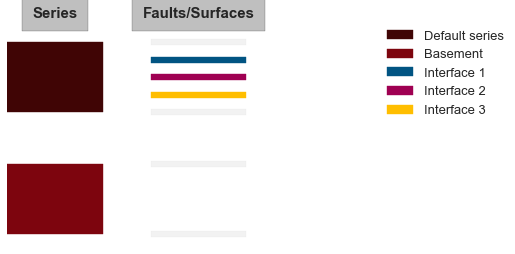

In [6]:
gp.map_series_to_surfaces(geo_model, 
                            {"Default series": ["Interface {}".format(n + 1) for n in range(3)]})

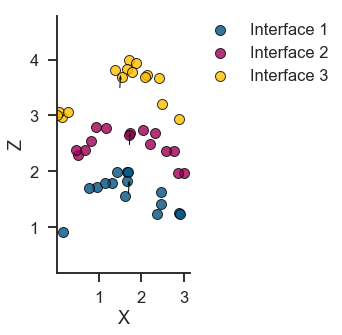

In [7]:
gp.plot.plot_data(geo_model)

In [8]:
gp.set_interpolation_data(
    geo_model, output='geology', compile_theano=True, theano_optimizer='fast_compile'
)

Compiling theano function...
Compilation Done!


,values
dtype,float64
output,geology
theano_optimizer,fast_compile
device,cpu
verbosity,[]


In [9]:
sol = gp.compute_model(geo_model, compute_mesh=True)

In [10]:
gp.plot.plot_surfaces_3d_ipv(geo_model)

In [11]:
from stochasticsurf import StochasticSurfaceScipy

In [12]:
surfaces = ["Interface {}".format(n + 1) for n in range(3)]
surfaces

['Interface 1', 'Interface 2', 'Interface 3']

In [13]:
stochastic_surfaces = []
for surface in surfaces:
    stochsurf = StochasticSurfaceScipy(geo_model, surface)  # create stochastic surf obj
    stochastic_surfaces.append(stochsurf)  

In [14]:
for stochsurf in stochastic_surfaces:
    stochsurf.parametrize_surfpts_naive(factor=0.01, direction="Z")

In [20]:
StochasticSurfaceScipy.modify_surface_points_all()

In [21]:
sol = gp.compute_model(geo_model, compute_mesh=True)
gp.plot.plot_surfaces_3d_ipv(geo_model)